In [1]:
# importing pertinent libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import VAR

from statsmodels.stats.diagnostic import het_arch
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dataset

In [2]:
pce_var=pd.read_excel('dataset_for_var.xlsx')
pce_var.head()

# year 1980 removed -- difficult to locate data for Total Federal Outlay

,Date,PCE,Disposable Personal Income,Price Index (PCE),Total Federal Outlay
0,1981-01-01,1870.0,2160.1,41.011,63.339
1,1981-02-01,1884.2,2175.0,41.426,53.749
2,1981-03-01,1902.9,2196.1,41.715,53.938
3,1981-04-01,1904.4,2199.2,41.897,56.999
4,1981-05-01,1913.8,2213.2,42.085,54.414


# 1. Preceding with basic visualisation

In [3]:
pce_var.info()

# date column identified as datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        528 non-null    datetime64[ns]
 1   PCE                         528 non-null    float64       
 2   Disposable Personal Income  528 non-null    float64       
 3   Price Index (PCE)           528 non-null    float64       
 4   Total Federal Outlay        528 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 20.8 KB


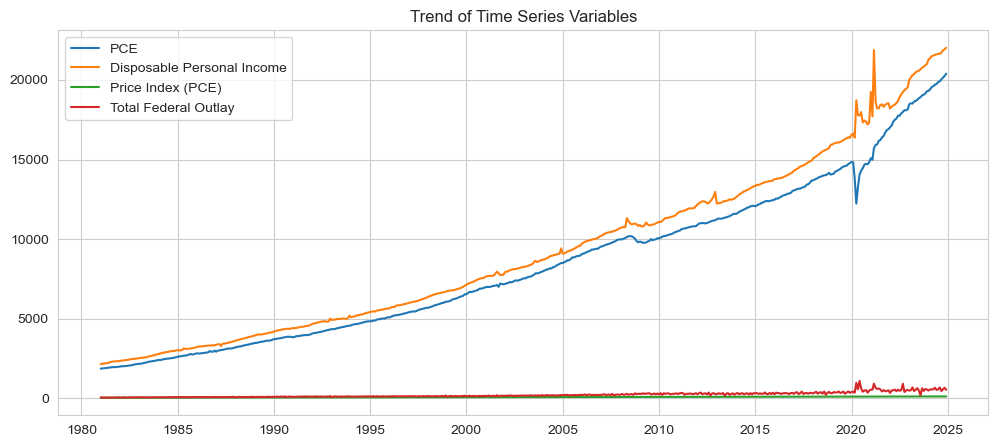

In [4]:
# converting Data into an index
pce_var.set_index('Date', inplace=True)

plt.figure(figsize=(12,5))
for column in pce_var.columns:
    plt.plot(pce_var.index, pce_var[column], label=column)
plt.legend()
plt.title("Trend of Time Series Variables")
plt.show()

# 2. Pre-processing

In [5]:
pce_var.isnull().sum()

# no null values

PCE                           0
Disposable Personal Income    0
Price Index (PCE)             0
Total Federal Outlay          0
dtype: int64

In [11]:
# checking stationarity of data with the ADF test

def adf_test(series):
    result=adfuller(series.dropna())
    return {
        "Test Statistic": result[0],
        "p-value": result[1],
        "Lags Used": result[2],    }

# ADF test before differencing
print("ADF Test Before Differencing:")
for col in pce_var.columns:
    print(f"{col}: {adf_test(pce_var[col])}")

# ADF test after differencing
print("\nADF Test After Differencing:")
for col in pce_var.columns:
    print(f"{col}: {adf_test(pce_var[col].diff().dropna())}")

ADF Test Before Differencing:
PCE: {'Test Statistic': 3.6831854729482725, 'p-value': 1.0, 'Lags Used': 11}
Disposable Personal Income: {'Test Statistic': 4.567398415272359, 'p-value': 1.0, 'Lags Used': 14}
Price Index (PCE): {'Test Statistic': 1.0453732981083201, 'p-value': 0.9947223514783535, 'Lags Used': 15}
Total Federal Outlay: {'Test Statistic': 0.7692911797457369, 'p-value': 0.9911239456635901, 'Lags Used': 19}

ADF Test After Differencing:
PCE: {'Test Statistic': -4.9077136317350964, 'p-value': 3.368851754917901e-05, 'Lags Used': 11}
Disposable Personal Income: {'Test Statistic': -4.444373306850141, 'p-value': 0.0002475216938150734, 'Lags Used': 15}
Price Index (PCE): {'Test Statistic': -3.3855298583542024, 'p-value': 0.011462160376977752, 'Lags Used': 14}
Total Federal Outlay: {'Test Statistic': -6.294462598839318, 'p-value': 3.5336467391847354e-08, 'Lags Used': 18}


In [13]:
# as observed, first-order differencing has been sufficient to make the dataset stationary
# creating a new dataset with the differenced values

pce_var_diff=pd.DataFrame(pce_var.diff().dropna())
pce_var_diff.head()

,PCE,Disposable Personal Income,Price Index (PCE),Total Federal Outlay
Date,,,,
1981-02-01,14.2,14.9,0.415,-9.590
1981-03-01,18.7,21.1,0.289,0.189
1981-04-01,1.5,3.1,0.182,3.061
1981-05-01,9.4,14.0,0.188,-2.585
1981-06-01,20.7,20.8,0.168,0.652


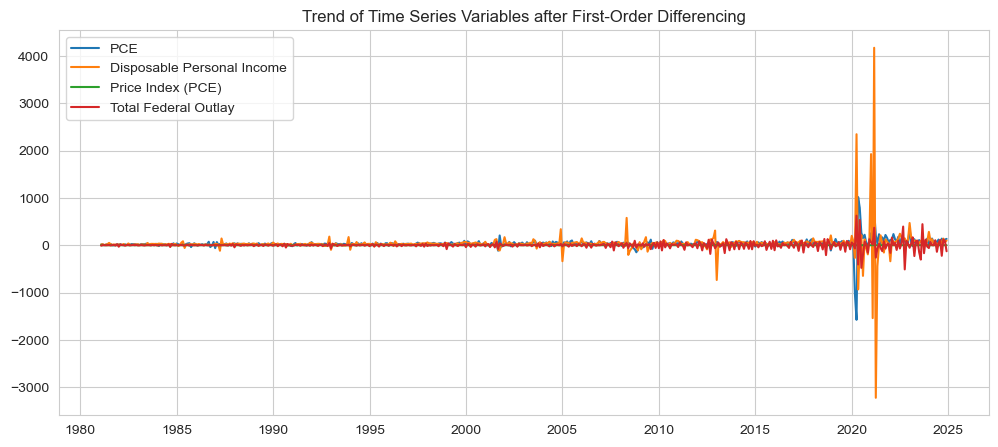

In [15]:
plt.figure(figsize=(12,5))
for col in pce_var_diff:
    plt.plot(pce_var_diff.index,pce_var_diff[col],label=col)
plt.legend()
plt.title("Trend of Time Series Variables after First-Order Differencing")
plt.show()

# 3. Splitting the dataset -- train and test

In [17]:
# Splitting data into training and testing sets (80-20 split) while keeping the index
split_point=int(len(pce_var_diff) * 0.8)  # 80% for training

train=pce_var_diff.iloc[:split_point].copy()
test=pce_var_diff.iloc[split_point:].copy()

# Display index of train and test sets
print("Train Index Sample:", train.index[:5])
print("Test Index Sample:", test.index[:5])

Train Index Sample: DatetimeIndex(['1981-02-01', '1981-03-01', '1981-04-01', '1981-05-01',
               '1981-06-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
Test Index Sample: DatetimeIndex(['2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01',
               '2016-07-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


# 4. Standardising data after the split

In [19]:
# firstly, making the variables independent of the unit of measurement, thereby permitting comparisons of variables in the model
# secondly, doing after the splitting to ensure no influence of the test data seeps into the train data

scaler=StandardScaler()

train_scaled=pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)

test_scaled=pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

train_scaled.head()

,PCE,Disposable Personal Income,Price Index (PCE),Total Federal Outlay
Date,,,,
1981-02-01,-0.373935,-0.192044,1.928030,-0.288829
1981-03-01,-0.223409,-0.098187,1.063358,-0.014579
1981-04-01,-0.798753,-0.370676,0.329073,0.065966
1981-05-01,-0.534496,-0.205669,0.370248,-0.092375
1981-06-01,-0.156509,-0.102728,0.232998,-0.001594


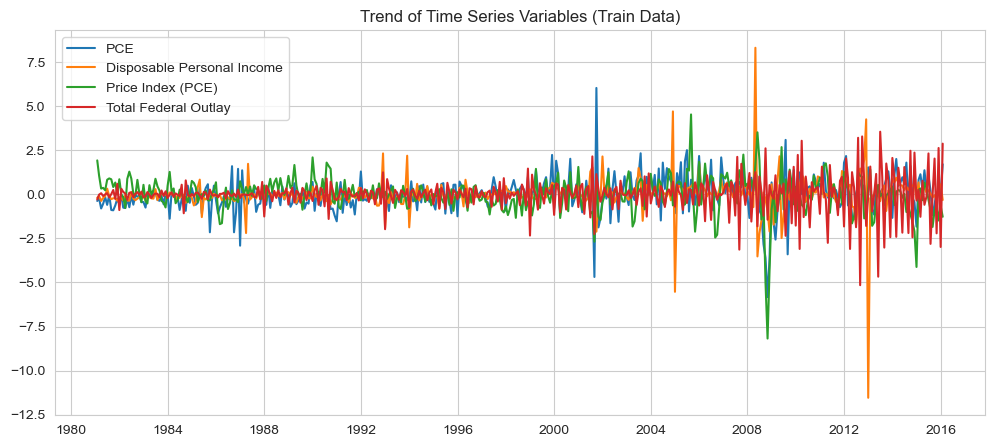

In [21]:
plt.figure(figsize=(12,5))
for col in train_scaled:
    plt.plot(train_scaled.index,train_scaled[col],label=col)
plt.legend()
plt.title("Trend of Time Series Variables (Train Data)")
plt.show()

# 5. Building the VAR model

In [23]:
# Selecting the optimal lag length
model=VAR(train_scaled)
lag_order=model.select_order(maxlags=30)
print(lag_order.summary())

C:\Users\Neha Rana\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0     -0.01085     0.02975      0.9892    0.005246
1      -0.8445     -0.6415      0.4298     -0.7640
2       -1.334    -0.9687*      0.2634      -1.189
3       -1.467     -0.9395      0.2306      -1.258
4       -1.530     -0.8401      0.2165      -1.257
5       -1.602     -0.7496      0.2015     -1.264*
6       -1.605     -0.5896      0.2011      -1.202
7       -1.608     -0.4302      0.2006      -1.141
8       -1.715     -0.3754      0.1802      -1.184
9       -1.708     -0.2056      0.1817      -1.112
10      -1.688    -0.02372      0.1854      -1.029
11      -1.787     0.03977      0.1681      -1.063
12      -1.830      0.1596      0.1613      -1.041
13      -1.822      0.3293      0.1627     -0.9696
14      -1.784      0.5301      0.1694     -0.8669
15      -1.824      0.6523      0.1630     -0.8427
16      -1.807      0.8320     

In [25]:
# selecting the optimal length, based on the AIC
# AIC, since our focus is on enhancing the model accuracy

optimal_lag=28  # fitting the lag length in the model
results=model.fit(optimal_lag)

# Print summary
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, May, 2025
Time:                     17:57:51
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    2.64030
Nobs:                     393.000    HQIC:                 -0.118904
Log likelihood:          -1399.31    FPE:                   0.155151
AIC:                     -1.93009    Det(Omega_mle):       0.0564577
--------------------------------------------------------------------
Results for equation PCE
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -0.005154         0.048497           -0.106           0.915
L1.PCE                                -0.267781         0.068999           -3.881           

# 6. Residual analysis

In [27]:
# 1. fundamental -- stability check

residuals=pd.DataFrame(results.resid)

stability=results.is_stable()
print(f"VAR Model Stability: {stability}")

VAR Model Stability: True


In [29]:
# 2. autocorrelation -- with all p-values > 0.05, we conclude that there is no autocorrelation present

# storing Ljung-Box test results for each variable
ljung_box_results={}

for col in residuals.columns:
    ljung_box_results[col] = acorr_ljungbox(residuals[col], lags=[optimal_lag], return_df=True)

for col, result in ljung_box_results.items():
    print(f"Ljung-Box test results for {col}:\n", result, "\n")

Ljung-Box test results for PCE:
      lb_stat  lb_pvalue
28  5.129072   0.999999 

Ljung-Box test results for Disposable Personal Income:
       lb_stat  lb_pvalue
28  10.634771   0.998761 

Ljung-Box test results for Price Index (PCE):
      lb_stat  lb_pvalue
28  6.244075   0.999995 

Ljung-Box test results for Total Federal Outlay:
       lb_stat  lb_pvalue
28  24.927451   0.631781 



In [31]:
# 3. heteroscedasticity -- with p-values < 0.05 for all except PCE heteroscedasticity present in the 3 variables' residuals

for col in residuals.columns:
    arch_test = het_arch(residuals[col])
    print(f"ARCH Test for {col}: p-value={arch_test[1]}")

ARCH Test for PCE: p-value=2.334713449392325e-10
ARCH Test for Disposable Personal Income: p-value=0.6264495027666
ARCH Test for Price Index (PCE): p-value=0.013638476854553721
ARCH Test for Total Federal Outlay: p-value=4.8162390428104e-11


In [137]:
# 4. normality -- with p-values < 0.05, we conclude that all residuals are not normally distributed

# storing Jarque-Bera test results for each variable
jb_results={}

for col in residuals.columns:
    jb_stat, jb_pvalue=jarque_bera(residuals[col])
    jb_results[col]={"JB Statistic": jb_stat, "p-value": jb_pvalue}

for col, result in jb_results.items():
    print(f"Jarque-Bera test results for {col}:\n", result, "\n")

Jarque-Bera test results for PCE:
 {'JB Statistic': 141.36648623826315, 'p-value': 2.007509228187666e-31} 

Jarque-Bera test results for Disposable Personal Income:
 {'JB Statistic': 2761.82181411639, 'p-value': 0.0} 

Jarque-Bera test results for Price Index (PCE):
 {'JB Statistic': 18.329740742115426, 'p-value': 0.00010465196095159507} 

Jarque-Bera test results for Total Federal Outlay:
 {'JB Statistic': 46.731922246532605, 'p-value': 7.116918947447088e-11} 



In [35]:
# additional: attempting transformation to see if the residuals pass the ARCH test

# i. Square-Root transformation
df_sqrt=pce_var.copy()
for col in df_sqrt:
    df_sqrt[col] = np.sqrt(df_sqrt[col] + 1)

model_sq=VAR(df_sqrt)
results_sq=model_sq.fit(28)
residuals_sq=pd.DataFrame(results_sq.resid)

for col in residuals_sq.columns:
    arch_test_sq=het_arch(residuals_sq[col])
    print(f"ARCH Test for {col}: p-value = {arch_test_sq[1]}")

ARCH Test for PCE: p-value = 1.5118978699721311e-44
ARCH Test for Disposable Personal Income: p-value = 0.6611873609511607
ARCH Test for Price Index (PCE): p-value = 1.1661697047852165e-08
ARCH Test for Total Federal Outlay: p-value = 0.988546579007642


C:\Users\Neha Rana\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [37]:
# ii. log transformation

df_log=pce_var.copy()
for col in df_log:
    df_log[col]=np.log(df_sqrt[col] + 1)  # Adding 1 to avoid log(0)

model_log=VAR(df_log)
results_log= model_log.fit(28)
residuals_log=pd.DataFrame(results_log.resid)

for col in residuals.columns:
    arch_test_log=het_arch(residuals_log[col])
    print(f"ARCH Test for {col}: p-value = {arch_test_log[1]}")

ARCH Test for PCE: p-value = 1.3457587800150124e-22
ARCH Test for Disposable Personal Income: p-value = 0.8661147115614406
ARCH Test for Price Index (PCE): p-value = 1.863833695643217e-08
ARCH Test for Total Federal Outlay: p-value = 0.9943561111396559


C:\Users\Neha Rana\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [39]:
# with both transformation being ineffective, settling with the orginal dataset (first-order differencing + standardised)

# 7. Forecasting

In [41]:
# Forecasting for the test period
test_forecast=results.forecast(train_scaled.values[-optimal_lag:], steps=len(test_scaled))

# Convert to DataFrame
test_forecast_df=pd.DataFrame(test_forecast, columns=train_scaled.columns, index=test_scaled.index)

# Forecasting beyond the test period (Extended Forecast -- 36 months, i.e., 3 years)
extended_steps=36  
last_test_values=test_forecast[-optimal_lag:]  # Use last few test period forecasts as input

extended_forecast=results.forecast(last_test_values, steps=extended_steps)

# Convert to DataFrame
extended_forecast_df=pd.DataFrame(extended_forecast, columns=train_scaled.columns)

# Assign future index to extended forecast
future_index=pd.date_range(start=test_scaled.index[-1], periods=extended_steps+1, freq='M')[1:]
extended_forecast_df.index=future_index

C:\Users\Neha Rana\AppData\Local\Temp\ipykernel_35832\1082255464.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index=pd.date_range(start=test_scaled.index[-1], periods=extended_steps+1, freq='M')[1:]


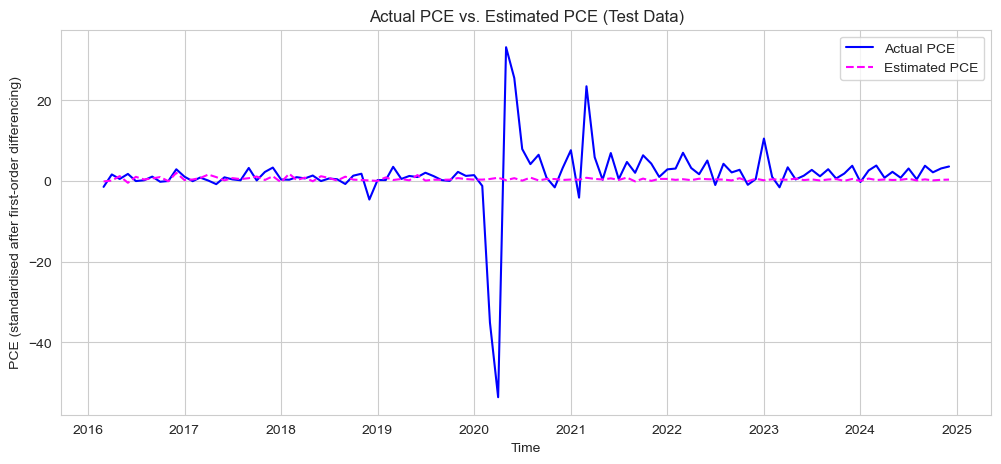

In [43]:
plt.figure(figsize=(12,5))
plt.plot(test_scaled.index, test_scaled["PCE"], label="Actual PCE", color='blue')

# Plot forecasted PCE for test period
plt.plot(test_forecast_df.index, test_forecast_df["PCE"], label="Estimated PCE", linestyle='--', color='magenta')

plt.legend()
plt.title("Actual PCE vs. Estimated PCE (Test Data)")
plt.xlabel("Time")
plt.ylabel("PCE (standardised after first-order differencing)")
plt.show()

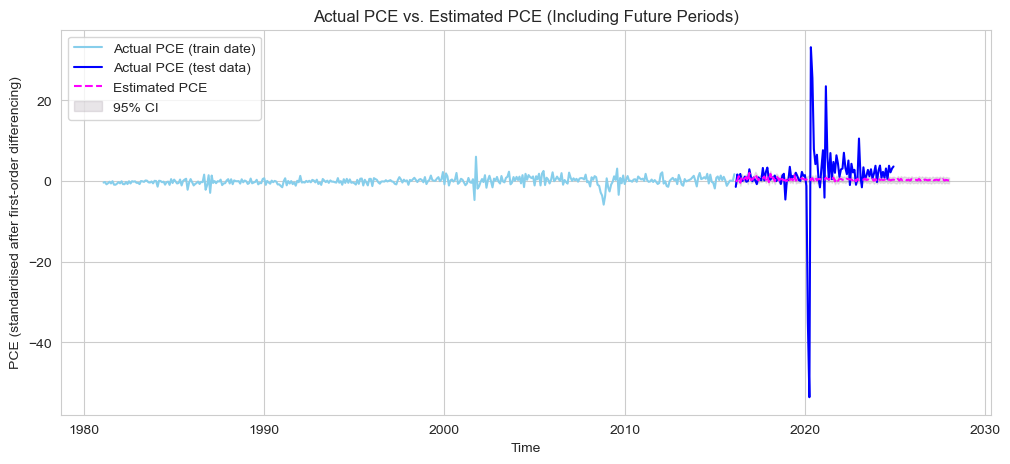

In [45]:
plt.figure(figsize=(12, 5))
plt.plot(train_scaled.index, train_scaled["PCE"], label="Actual PCE (train date)", color='#87CEEB')
plt.plot(test_scaled.index, test_scaled["PCE"], label="Actual PCE (test data)", color='blue')

# Combine both forecasted periods into one DataFrame (ensuring continuity)
combined_forecast=pd.concat([test_forecast_df, extended_forecast_df])

# Plot as a single continuous line
plt.plot(combined_forecast.index, combined_forecast["PCE"], label="Estimated PCE", linestyle='--', color='magenta')

std_dev = combined_forecast["PCE"].std()  # Compute standard deviation
combined_forecast["lower_95"]=combined_forecast["PCE"] - 1.96 * std_dev
combined_forecast["upper_95"]=combined_forecast["PCE"] + 1.96 * std_dev

# Plot the 95% Confidence Interval as a shaded region
plt.fill_between(combined_forecast.index, 
                 combined_forecast["lower_95"], 
                 combined_forecast["upper_95"], 
                 color='#8c7e8c', alpha=0.2, label="95% CI")  # Pastel green

plt.legend()
plt.title("Actual PCE vs. Estimated PCE (Including Future Periods)")
plt.xlabel("Time")
plt.ylabel("PCE (standardised after first-order differencing)")
plt.show()

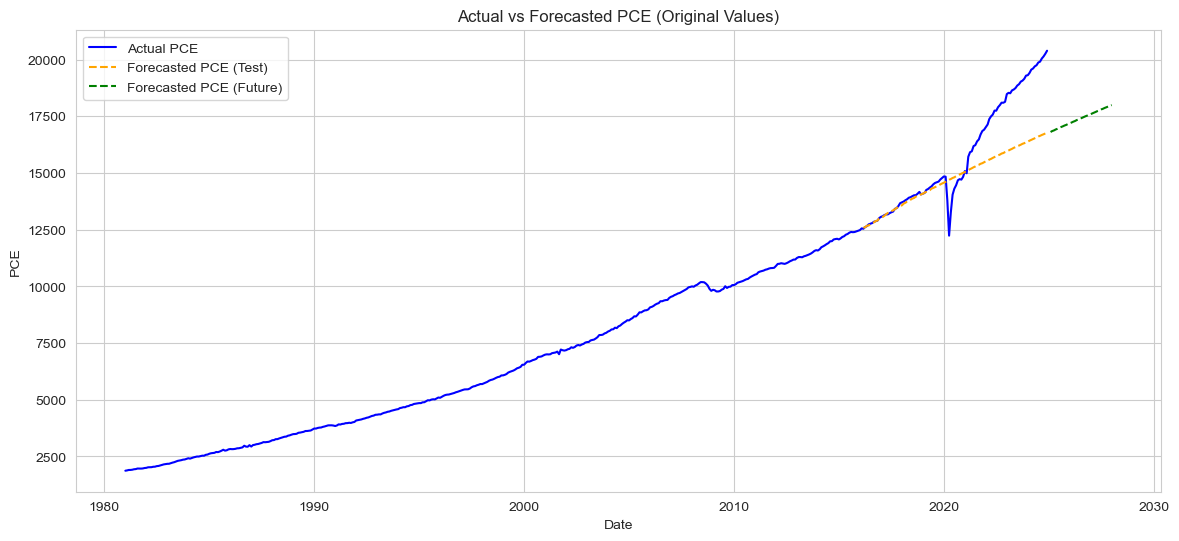

In [47]:
# Inverse transform forecasted values
test_forecast_inv=pd.DataFrame(
    scaler.inverse_transform(test_forecast_df),
    columns=test_forecast_df.columns,
    index=test_forecast_df.index)

extended_forecast_inv=pd.DataFrame(
    scaler.inverse_transform(extended_forecast_df),
    columns=extended_forecast_df.columns,
    index=extended_forecast_df.index)

# Get the last actual PCE value before the test set starts
last_actual_pce_value=pce_var['PCE'].iloc[split_point]

# Inverse differencing for test forecast
pce_test_forecast_original=test_forecast_inv["PCE"].cumsum() + last_actual_pce_value

# For extended forecast, use the last value from test forecast as the new base
last_forecasted_pce_value=pce_test_forecast_original.iloc[-1]
pce_extended_forecast_original=extended_forecast_inv["PCE"].cumsum() + last_forecasted_pce_value

plt.figure(figsize=(14,6))

# Actual PCE values (original, not differenced)
plt.plot(pce_var.index, pce_var["PCE"], label="Actual PCE", color='blue')

# Forecasted PCE for test data
plt.plot(pce_test_forecast_original.index, pce_test_forecast_original, 
         label="Forecasted PCE (Test)", linestyle='--', color='orange')

# Forecasted PCE for extended future
plt.plot(pce_extended_forecast_original.index, pce_extended_forecast_original, 
         label="Forecasted PCE (Future)", linestyle='--', color='green')

plt.title("Actual vs Forecasted PCE (Original Values)")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.legend()
plt.grid(True)
plt.show()

# 8. IRF (Impulse Response Function)

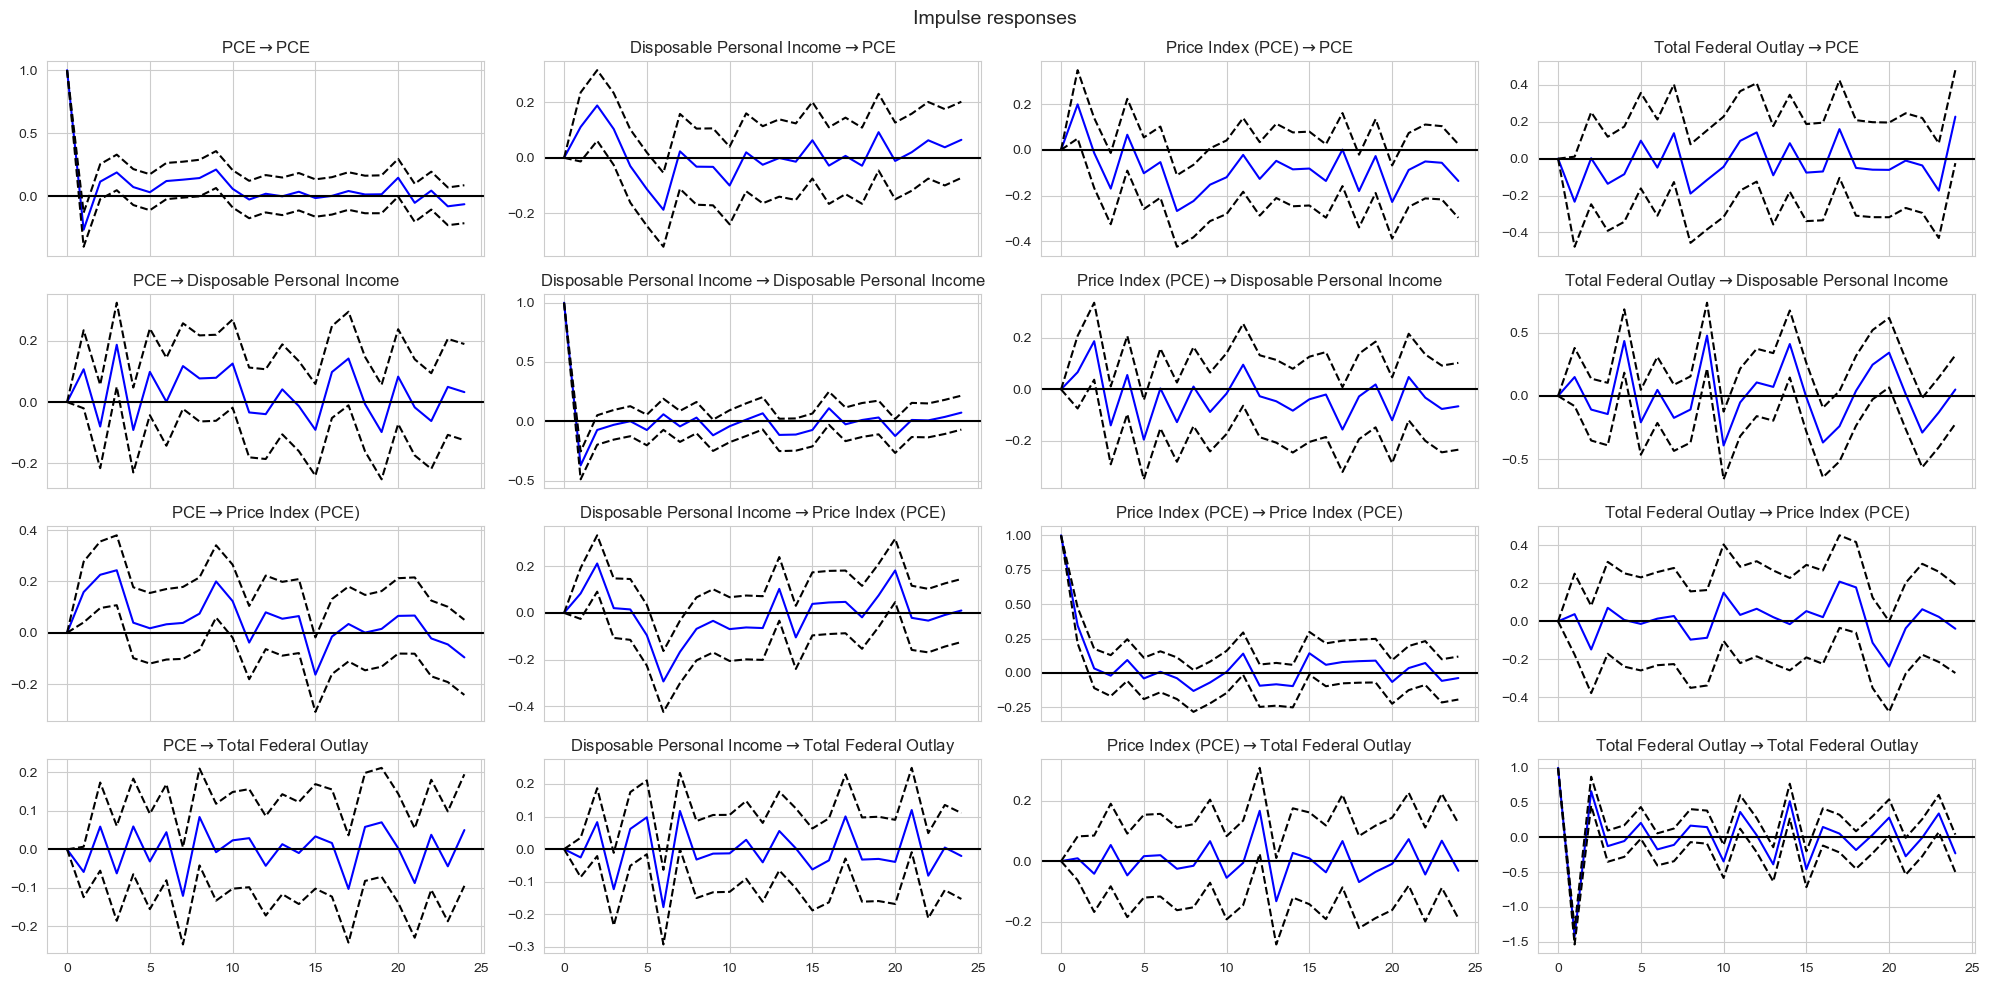

In [86]:
irf=results.irf(24)  # 24-month IRF

# Plot IRFs for all variables
irf.plot(orth=False, figsize=(20, 10))
plt.tight_layout()  # Ensures spacing is handled properly
plt.show()

# 9. Assessing model

In [55]:
pce_test_forecast_original

Date
2016-03-01    12577.413648
2016-04-01    12606.525875
2016-05-01    12668.773451
2016-06-01    12681.638450
2016-07-01    12738.642745
                  ...     
2024-08-01    16635.082063
2024-09-01    16673.335768
2024-10-01    16703.982117
2024-11-01    16738.832796
2024-12-01    16775.190044
Name: PCE, Length: 106, dtype: float64

In [71]:
pce_test_actual=pce_var.loc['2016-03-01':'2024-12-01', 'PCE']
pce_test_actual

Date
2016-03-01    12537.0
2016-04-01    12611.5
2016-05-01    12652.7
2016-06-01    12731.2
2016-07-01    12756.7
               ...   
2024-08-01    19905.0
2024-09-01    20044.1
2024-10-01    20134.5
2024-11-01    20253.6
2024-12-01    20387.2
Name: PCE, Length: 106, dtype: float64

In [73]:
mae=mean_absolute_error(pce_test_actual,pce_test_forecast_original)
mse=mean_squared_error(pce_test_actual,pce_test_forecast_original)
r2=r2_score(pce_test_actual,pce_test_forecast_original)

print('Mean Absolute Error:',mae)
print('Mean Squared Error:',mse)
print('R-Squared:',r2)

Mean Absolute Error: 1097.4978254799223
Mean Squared Error: 2660513.6378975976
R-Squared: 0.5489479071291594


# Revised model

In [76]:
pce_var_rev=pce_var.loc['2022-01-01':'2024-12-01']
pce_var_rev.head()

,PCE,Disposable Personal Income,Price Index (PCE),Total Federal Outlay
Date,,,,
2022-01-01,17017.8,18201.9,112.776,346.379914
2022-02-01,17136.1,18317.4,113.489,506.475496
2022-03-01,17371.4,18390.6,114.489,507.854543
2022-04-01,17493.8,18446.5,114.845,555.433548
2022-05-01,17569.9,18541.9,115.542,455.215709


# 1. Preceding with basic visualisation

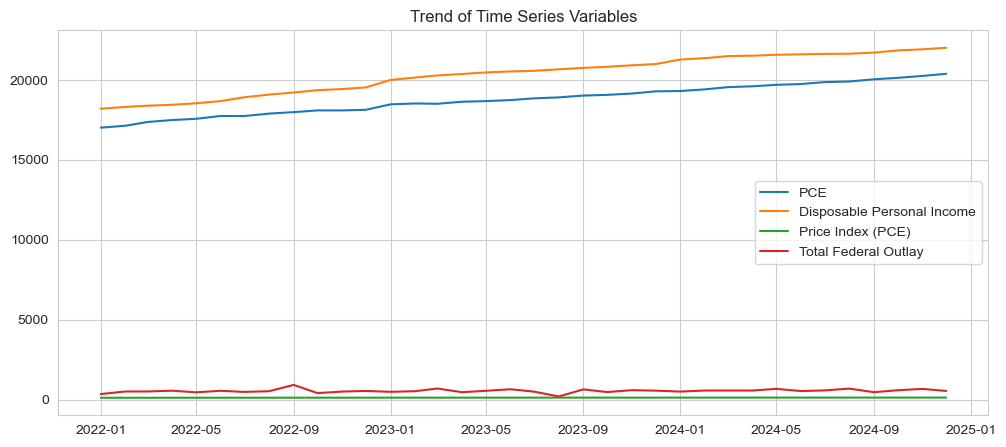

In [81]:
plt.figure(figsize=(12,5))
for column in pce_var_rev.columns:
    plt.plot(pce_var_rev.index, pce_var_rev[column], label=column) # focus on one column at a time
plt.legend()
plt.title("Trend of Time Series Variables")
plt.show()

# 2. Pre-processing

In [84]:
# checking stationarity of data with the ADF test

def adf_test(series):
    result=adfuller(series.dropna())
    return {
        "Test Statistic": result[0],
        "p-value": result[1],
        "Lags Used": result[2],    }

# ADF test before differencing
print("ADF Test Before Differencing:")
for col in pce_var_rev.columns:
    print(f"{col}: {adf_test(pce_var_rev[col])}")

# ADF test after differencing
print("\nADF Test After Differencing:")
for col in pce_var_rev.columns:
    print(f"{col}: {adf_test(pce_var_rev[col].diff().dropna())}")

ADF Test Before Differencing:
PCE: {'Test Statistic': -0.2755929459456354, 'p-value': 0.9288906740784303, 'Lags Used': 6}
Disposable Personal Income: {'Test Statistic': -1.824828557998321, 'p-value': 0.3682065230121768, 'Lags Used': 0}
Price Index (PCE): {'Test Statistic': -4.273846149479775, 'p-value': 0.000492888842119431, 'Lags Used': 0}
Total Federal Outlay: {'Test Statistic': -7.406171185323423, 'p-value': 7.335070412837061e-11, 'Lags Used': 0}

ADF Test After Differencing:
PCE: {'Test Statistic': -6.497403976613483, 'p-value': 1.1848512543589921e-08, 'Lags Used': 1}
Disposable Personal Income: {'Test Statistic': -4.609917721358714, 'p-value': 0.00012384053955604522, 'Lags Used': 0}
Price Index (PCE): {'Test Statistic': -4.588408537371686, 'p-value': 0.00013567548166564132, 'Lags Used': 0}
Total Federal Outlay: {'Test Statistic': -4.868214295013071, 'p-value': 4.019844789150151e-05, 'Lags Used': 4}


In [86]:
# first-order differencing for all variables
pce_var_rev_diff=pce_var_rev.diff().dropna()
pce_var_rev_diff.head()

,PCE,Disposable Personal Income,Price Index (PCE),Total Federal Outlay
Date,,,,
2022-02-01,118.3,115.5,0.713,160.095581
2022-03-01,235.3,73.2,1.000,1.379047
2022-04-01,122.4,55.9,0.356,47.579005
2022-05-01,76.1,95.4,0.697,-100.217839
2022-06-01,177.7,136.5,1.089,94.387216


Text(0, 0.5, 'Values')

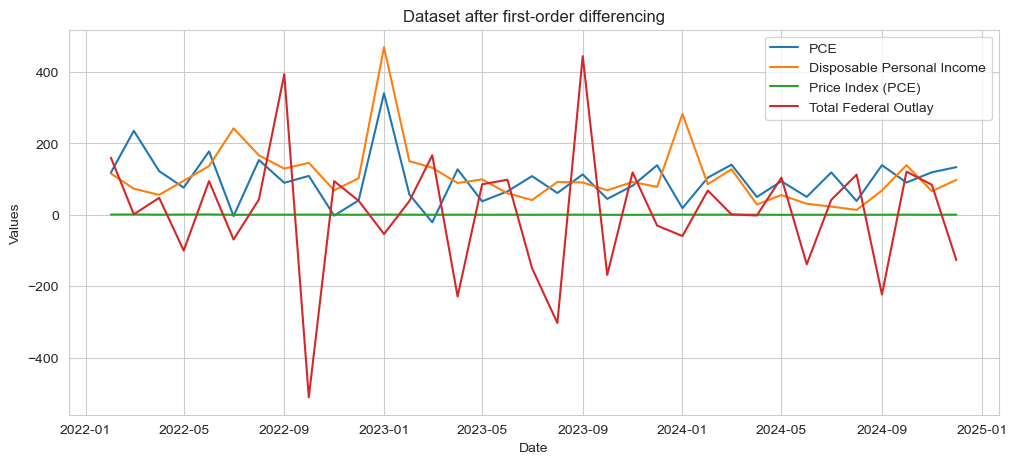

In [90]:
plt.figure(figsize=(12,5))

for col in pce_var_rev_diff.columns:
    plt.plot(pce_var_rev_diff.index,pce_var_rev_diff[col],label=col)

plt.legend()
plt.title('Dataset after first-order differencing')
plt.xlabel('Date')
plt.ylabel('Values')

# 3. Splitting the dataset -- train and test

In [96]:
split_point=int(len(pce_var_rev_diff) * 0.8)  # 80% for training

train_rev=pce_var_rev_diff.iloc[:split_point].copy()
test_rev=pce_var_rev_diff.iloc[split_point:].copy()

# Display index of train and test sets
print("Train Index Sample:", train_rev.index[:5])  # Check first few indexes
print("Test Index Sample:", test_rev.index[:5])  # Check first few indexes

Train Index Sample: DatetimeIndex(['2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
Test Index Sample: DatetimeIndex(['2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


# 4. Standardising the data

In [99]:
# Fit and transform the training set, keeping the index
train_scaled_rev=pd.DataFrame(scaler.fit_transform(train_rev), columns=train_rev.columns, index=train_rev.index)

# Transform the test set, keeping the index
test_scaled_rev=pd.DataFrame(scaler.transform(test_rev), columns=test_rev.columns, index=test_rev.index)

# Display the first few rows to check
train_scaled_rev.head()

,PCE,Disposable Personal Income,Price Index (PCE),Total Federal Outlay
Date,,,,
2022-02-01,0.308177,-0.058178,1.282762,0.805257
2022-03-01,1.903352,-0.547571,2.366019,-0.055343
2022-04-01,0.364076,-0.747725,-0.064704,0.195165
2022-05-01,-0.267177,-0.290727,1.222371,-0.606225
2022-06-01,1.118035,0.184783,2.701942,0.448970


# 5. Building the revised VAR model

In [108]:
# Selecting the optimal lag length
model_rev=VAR(train_scaled_rev)
lag_order=model_rev.select_order(maxlags=4)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0     -0.2892   -0.09290*     0.7490*    -0.2372*
1      0.1627       1.144       1.206      0.4231
2      0.2886       2.056       1.556      0.7574
3    -0.01907       2.533       1.648      0.6581
4    -0.9681*       2.370       1.546    -0.08257
-------------------------------------------------


C:\Users\Neha Rana\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [110]:
optimal_lag=4
results_rev=model_rev.fit(optimal_lag)

# Print summary
print(results_rev.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, May, 2025
Time:                     18:27:19
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    2.36972
Nobs:                     24.0000    HQIC:                -0.0825744
Log likelihood:          -56.6009    FPE:                    1.54633
AIC:                    -0.968099    Det(Omega_mle):        0.181556
--------------------------------------------------------------------
Results for equation PCE
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                -0.291531         0.264879           -1.101           0.271
L1.PCE                               -0.748609         0.519561           -1.441           0.15

# 6. Residual analysis

In [129]:
# 1. fundamental -- stability check

residuals_rev=pd.DataFrame(results_rev.resid)

stability=results_rev.is_stable()
print(f"VAR Model Stability: {stability}")

VAR Model Stability: True


In [117]:
# 2. autocorrelation -- with all p-values > 0.05, we conclude that there is no autocorrelation present

# storing Ljung-Box test results for each variable
ljung_box_results_rev={}

for col in residuals_rev.columns:
    ljung_box_results_rev[col] = acorr_ljungbox(residuals_rev[col], lags=[optimal_lag], return_df=True)

for col, result in ljung_box_results.items():
    print(f"Ljung-Box test results for {col}:\n", result, "\n")

Ljung-Box test results for PCE:
      lb_stat  lb_pvalue
28  5.129072   0.999999 

Ljung-Box test results for Disposable Personal Income:
       lb_stat  lb_pvalue
28  10.634771   0.998761 

Ljung-Box test results for Price Index (PCE):
      lb_stat  lb_pvalue
28  6.244075   0.999995 

Ljung-Box test results for Total Federal Outlay:
       lb_stat  lb_pvalue
28  24.927451   0.631781 



In [121]:
# 3. heteroscedasticity -- with p-values > 0.05 for all except PCE no heteroscedasticity present in the 3 variables' residuals

for col in residuals_rev.columns:
    arch_test_rev=het_arch(residuals_rev[col])
    print(f"ARCH Test for {col}: p-value={arch_test_rev[1]}")

ARCH Test for PCE: p-value=0.7568213885192016
ARCH Test for Disposable Personal Income: p-value=0.767747599473825
ARCH Test for Price Index (PCE): p-value=0.9085945379003307
ARCH Test for Total Federal Outlay: p-value=0.697348766991874


In [141]:
# 4. normality -- with p-values > 0.05, we conclude that all residuals are normally distributed

jb_results_rev={}

for col in residuals_rev.columns:
    jb_stat, jb_pvalue=jarque_bera(residuals_rev[col])
    jb_results_rev[col]={"JB Statistic": jb_stat, "p-value": jb_pvalue}

for col, result in jb_results_rev.items():
    print(f"Jarque-Bera test results for {col}:\n", result, "\n")

Jarque-Bera test results for PCE:
 {'JB Statistic': 1.4051477299656847, 'p-value': 0.49530880374108754} 

Jarque-Bera test results for Disposable Personal Income:
 {'JB Statistic': 5.661269565523859, 'p-value': 0.058975405214280616} 

Jarque-Bera test results for Price Index (PCE):
 {'JB Statistic': 3.3199239212860014, 'p-value': 0.1901462130036307} 

Jarque-Bera test results for Total Federal Outlay:
 {'JB Statistic': 2.5086758840923906, 'p-value': 0.28526464744832597} 



# 7. Forecasting

In [144]:
# Forecasting for the test period
test_forecast=results_rev.forecast(train_scaled_rev.values[-optimal_lag:], steps=len(test_scaled_rev))

# Convert to DataFrame
test_forecast_df=pd.DataFrame(test_forecast, columns=train_scaled_rev.columns, index=test_scaled_rev.index)

# Forecasting beyond the test period (Extended Forecast)
extended_steps=24  # Set the number of steps beyond the test period
last_test_values=test_forecast[-optimal_lag:]  # Use last few test period forecasts as input

extended_forecast=results_rev.forecast(last_test_values, steps=extended_steps)

# Convert to DataFrame
extended_forecast_df=pd.DataFrame(extended_forecast, columns=train_scaled_rev.columns)

# Assign future index to extended forecast with the start of the month
future_index=pd.date_range(start="2025-01-01", periods=extended_steps, freq='MS')

# Assign corrected index to the extended forecast DataFrame
extended_forecast_df.index=future_index

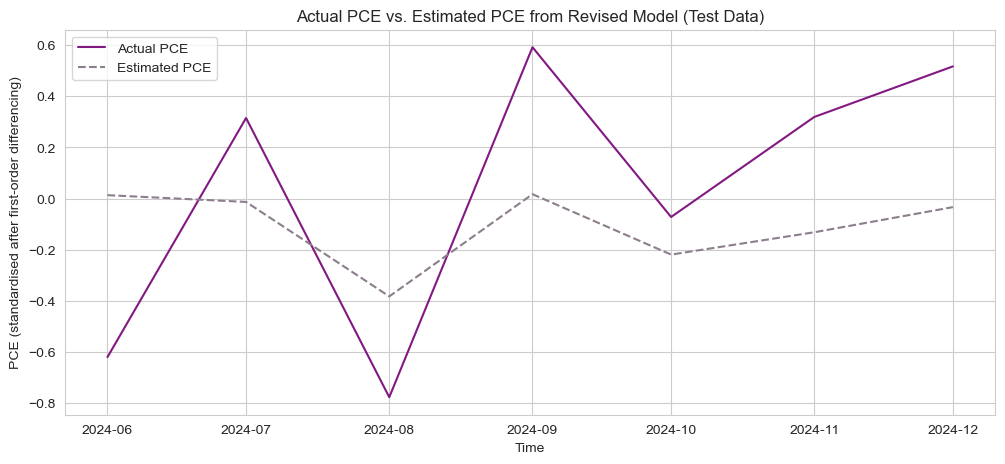

In [148]:
plt.figure(figsize=(12,5))
plt.plot(test_scaled_rev.index, test_scaled_rev["PCE"], label="Actual PCE", color='#821982')

# Plot forecasted PCE for test period
plt.plot(test_forecast_df.index, test_forecast_df["PCE"], label="Estimated PCE", linestyle='--', color='#8c7e8c')

plt.legend()
plt.title("Actual PCE vs. Estimated PCE from Revised Model (Test Data)")
plt.xlabel("Time")
plt.ylabel("PCE (standardised after first-order differencing)")
plt.show()

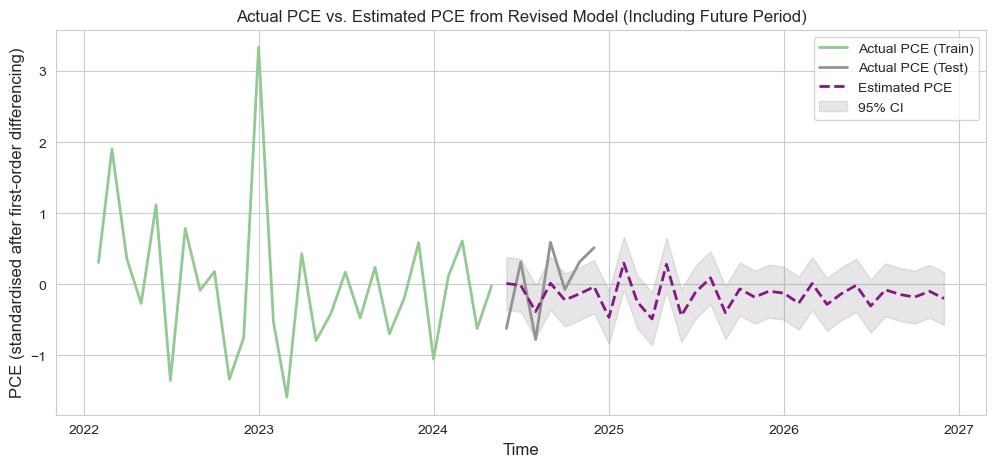

In [150]:
plt.figure(figsize=(12, 5))

# Plot actual PCE for train period
plt.plot(train_scaled_rev.index, train_scaled_rev["PCE"], label="Actual PCE (Train)", color='#93c993', linewidth=2)

# Plot actual PCE for test period
plt.plot(test_scaled_rev.index, test_scaled_rev["PCE"], label="Actual PCE (Test)", color='#8e978e', linewidth=2)

# Combine both forecasted periods into one DataFrame (ensuring continuity)
combined_forecast = pd.concat([test_forecast_df, extended_forecast_df])

# Plot estimated PCE as a continuous line
plt.plot(combined_forecast.index, combined_forecast["PCE"], label="Estimated PCE", linestyle='--', color='#821982', linewidth=2)


std_dev = combined_forecast["PCE"].std()  # Compute standard deviation
combined_forecast["lower_95"]=combined_forecast["PCE"] - 1.96 * std_dev
combined_forecast["upper_95"]=combined_forecast["PCE"] + 1.96 * std_dev

# Plot the 95% Confidence Interval as a shaded region
plt.fill_between(combined_forecast.index, 
                 combined_forecast["lower_95"], 
                 combined_forecast["upper_95"], 
                 color='#8c7e8c', alpha=0.2, label="95% CI")  # Pastel green

# Enhancing the visualization
plt.legend()#frameon=True, loc='upper right', fontsize=11)
plt.title("Actual PCE vs. Estimated PCE from Revised Model (Including Future Period)") #fontsize=14, fontweight='bold'
plt.xlabel("Time", fontsize=12)
plt.ylabel("PCE (standardised after first-order differencing)", fontsize=12)
#plt.grid(True, linestyle='--', alpha=0.6)  # Adding light gridlines
plt.show()

Text(0, 0.5, 'PCE')

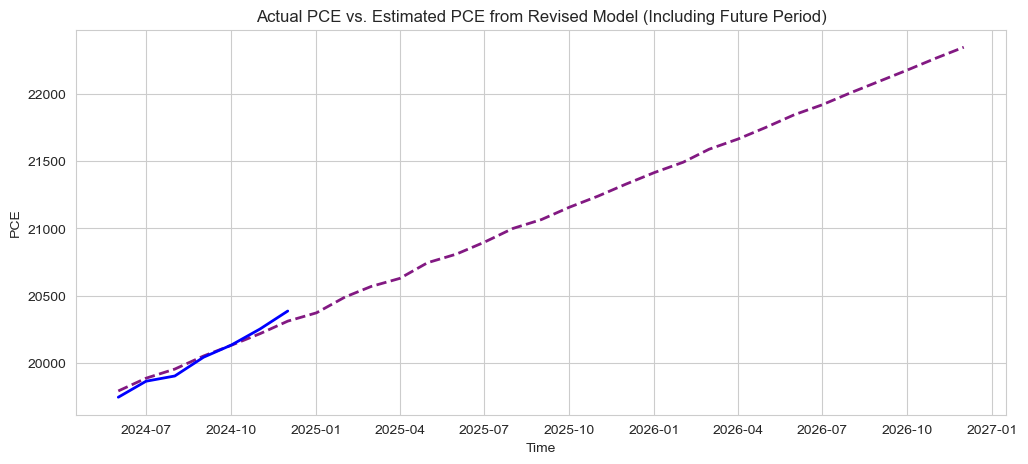

In [159]:
# Ensure the forecasted DataFrame contains only the columns that were standardized
forecasted_subset=combined_forecast[train_scaled_rev.columns]  # Select only standardized columns

# Step 1: Reverse Standardization
forecasted_original_scale=scaler.inverse_transform(forecasted_subset)

# Convert back to DataFrame with the correct index
forecasted_original_scale_df=pd.DataFrame(forecasted_original_scale, 
                                            columns=train_scaled_rev.columns, 
                                            index=combined_forecast.index)

# Step 2: Reverse Differencing
# Retrieve the last known actual PCE value before differencing
last_actual_pce=pce_var_rev["PCE"].iloc[-len(test_scaled_rev) - 1]  

# Use cumulative sum to restore original values
forecasted_original_scale_df["PCE"]=last_actual_pce + np.cumsum(forecasted_original_scale_df["PCE"])

forecasted_original_scale_df=forecasted_original_scale_df.rename(columns={'PCE':'Estimated PCE'})
pce_var_rev_test=pce_var_rev.loc['2024-06-01':'2024-12-01']
pce_var_rev_test=pce_var_rev_test.rename(columns={'PCE':'Actual PCE'})
forecasted_original_scale_df['Actual PCE']=pce_var_rev_test['Actual PCE']
forecasted_original_scale_df=forecasted_original_scale_df[['Actual PCE','Estimated PCE']]

plt.figure(figsize=(12,5))

plt.plot(forecasted_original_scale_df.index,forecasted_original_scale_df['Estimated PCE'],color='#821982', linewidth=2,linestyle='--')
plt.plot(forecasted_original_scale_df.index,forecasted_original_scale_df['Actual PCE'],color='blue',linewidth=2)

plt.title('Actual PCE vs. Estimated PCE from Revised Model (Including Future Period)')
plt.xlabel('Time')
plt.ylabel('PCE')

# 8. IRF

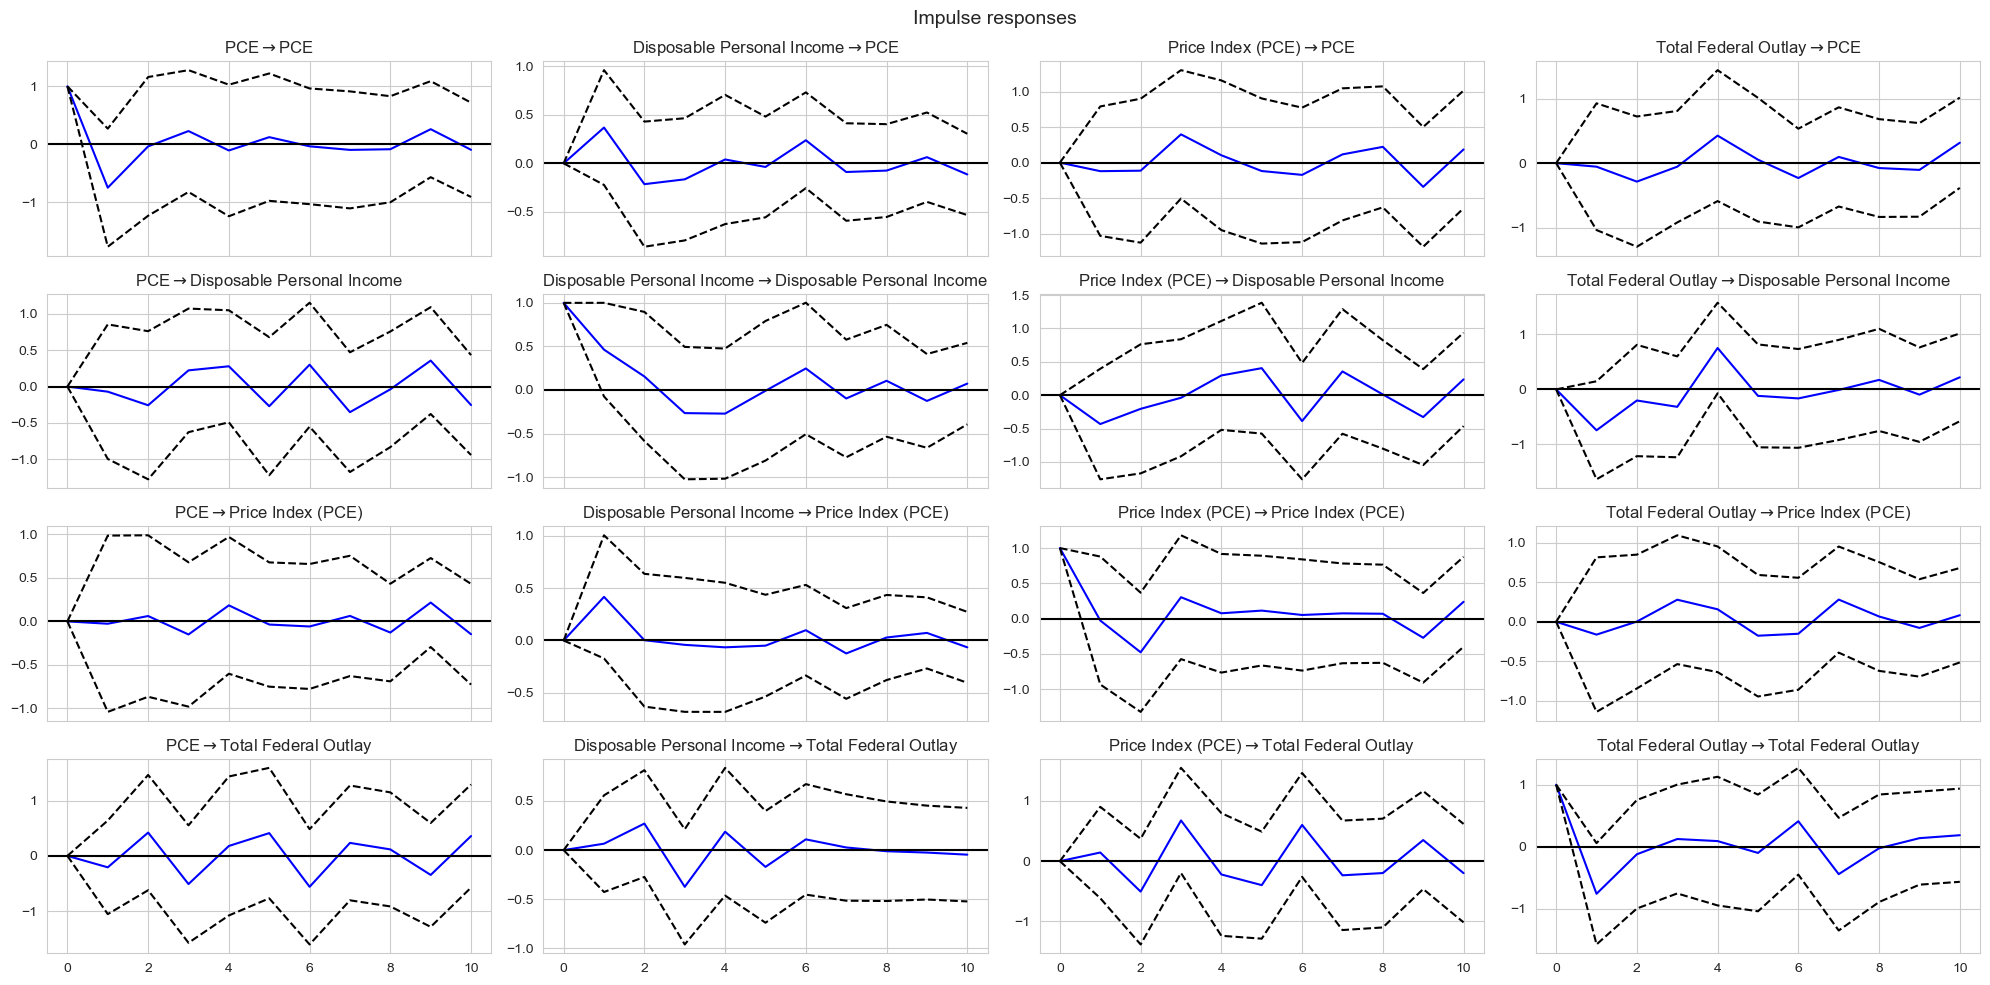

In [155]:
irf_rev=results_rev.irf(10)  # 10-period IRF

# Plot IRFs for all variables
irf_rev.plot(orth=False, figsize=(20, 10))
plt.tight_layout()
plt.show()

# 9. Assessing model

In [173]:
estimated_pce=forecasted_original_scale_df['Estimated PCE']
estimated_pce=estimated_pce.loc['2024-06-01':'2024-12-01']
estimated_pce

2024-06-01    19793.962920
2024-07-01    19888.686621
2024-08-01    19956.307456
2024-09-01    20053.251380
2024-10-01    20132.868039
2024-11-01    20218.889788
2024-12-01    20312.123735
Name: Estimated PCE, dtype: float64

In [175]:
mae=mean_absolute_error(pce_var_rev_test['Actual PCE'],estimated_pce)
mse=mean_squared_error(pce_var_rev_test['Actual PCE'],estimated_pce)
r2=r2_score(pce_var_rev_test['Actual PCE'],estimated_pce)

print('Mean Absolute Error:',mae)
print('Mean Squared Error:',mse)
print('R-Squared:',r2)

Mean Absolute Error: 34.38954499993218
Mean Squared Error: 1745.7248844972216
R-Squared: 0.960400150970909


In [177]:
# significant enhancement!
# VAR model enahnced from 0.55 to 0.96 with the revision in dataset

# critical to note tha VAR performed better than VAR
# r-squared from 0.86 to 0.96